In [1]:
# Board Game Reviews
# predict average_rating using the other columns
import pandas
# Read board_games.csv into a Dataframe called board_games using the Pandas library.
board_games = pandas.read_csv("board_games.csv")
# Print out the first few rows of board_games and look closely at the data.
print(board_games.head())

       id       type                                       name  \
0   12333  boardgame                          Twilight Struggle   
1  120677  boardgame                              Terra Mystica   
2  102794  boardgame                  Caverna: The Cave Farmers   
3   25613  boardgame  Through the Ages: A Story of Civilization   
4    3076  boardgame                                Puerto Rico   

   yearpublished  minplayers  maxplayers  playingtime  minplaytime  \
0         2005.0         2.0         2.0        180.0        180.0   
1         2012.0         2.0         5.0        150.0         60.0   
2         2013.0         1.0         7.0        210.0         30.0   
3         2006.0         2.0         4.0        240.0        240.0   
4         2002.0         2.0         5.0        150.0         90.0   

   maxplaytime  minage  users_rated  average_rating  bayes_average_rating  \
0        180.0    13.0        20113         8.33774               8.22186   
1        150.0    12.0

In [2]:
# Use the dropna Dataframe method with the axis argument set to 0 to 
# remove any rows that contain missing values.
# NOTICE: board_games doesn't change. need to return back to itself
board_games = board_games.dropna(axis=0)
# Remove any rows in board_games where users_rated equals 0. 
# This will remove any rows that have no reviews.
board_games = board_games[board_games["users_rated"] > 0]
# board_games.to_csv("board_games_output.cvs")

# Picking An Error Metric
I want to predict the average_rating column using the other columns, 
but I'll need to do some data exploration before I'm ready to do so.
It will help me understand the distribution of average_rating better, 
as well as select an error metric that 
I'll use to evaluate the performance of your machine learning model.


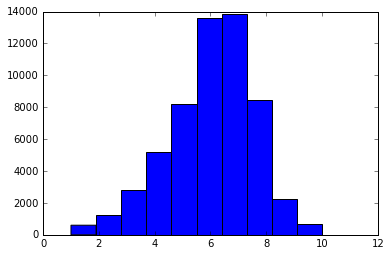

In [3]:
# Create a histogram of the average_rating column using the hist function.
import matplotlib.pyplot as plt
plt.hist(board_games["average_rating"])
plt.show()

In [4]:
# Calculate the standard deviation of the average_rating column and print it out.
import numpy
print(numpy.std(board_games["average_rating"]))

1.57881605958


In [5]:
# Calculate the mean of the average_rating column and print it out.
print(numpy.mean(board_games["average_rating"]))

6.01611284933


# Error metric
In this data set, using mean squared error as an error metric makes sense. This is because the data is continuous, and follows a somewhat normal distribution. We'll be able to compare our 
error to the standard deviation to see how good the model is at predictions.

# Plotting Clusters
I want to look at the data for patterns that may help me develop a machine learning model. 
One way to look for patterns is to use a clustering algorithm to create clusters, 
then plot them out.

First fit a KMeans class from the scikit-learn library. The KMeans class only works with numeric columns, so I have to extract the numeric columns of board_games before passing them into the fit method of the KMeans class.

To plot out the cluster assignment, I first find the mean and standard deviation of each row, then make a scatterplot for mean vs standard deviation, then shade the points according to their cluster assignment.


In [6]:
# Initialize the KMeans class with 5 clusters
from sklearn.cluster import KMeans
kmeans_model = KMeans(n_clusters=5)

In [7]:
# Extract the numeric columns of board_games, and assign to the variable numeric_columns.
cols = list(board_games.columns)
cols.remove("name")
cols.remove("id")
cols.remove("type")
numeric_columns = board_games[cols]
print(cols)
# Another way: numeric_columns = board_games.iloc[:, 4:]

['yearpublished', 'minplayers', 'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'average_rating', 'bayes_average_rating', 'total_owners', 'total_traders', 'total_wanters', 'total_wishers', 'total_comments', 'total_weights', 'average_weight']


In [8]:
# Fit the KMeans class to numeric_columns using the fit method
# kmeans_model changes itself. no need to assign to itself.
kmeans_model.fit_transform(numeric_columns)
# print(result)
# fit_transform() = fit() + return distance data (ND array of ND array)

# result2 = kmeans_model.fit(numeric_columns)
# print(result2)

# Extract the labels_ attribute of the KMeans class, and assign to the variable labels
labels = kmeans_model.labels_

In [9]:
# Plot out the cluster assignments.
# Use the apply method on numeric_columns with the keyword argument axis set to 1 
# to find the mean of each row.
game_mean = numeric_columns.apply(numpy.mean, axis=1)
print(game_mean[:5])

0    3806.296359
1    2662.195541
2    1979.243229
3    2467.201242
4    6360.675421
dtype: float64


In [10]:
# Use the apply method on numeric_columns with the keyword argument axis set to 1 to 
# find the standard deviation of each row. 
game_std = numeric_columns.apply(numpy.std, axis=1)
print(game_std[:5])

0     7450.209585
1     4933.084135
2     3514.218155
3     4367.915199
4    13321.625345
dtype: float64


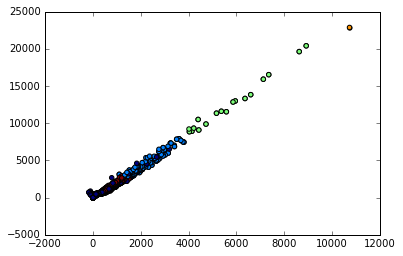

In [11]:
plt.scatter(x=game_mean, y=game_std, c=labels)
plt.show()

# Game clusters
It looks like most of the games are similar, but as the game attributes tend to increase in value (such as number of users who rated), there are fewer high quality games. So most games don't get played much, but a few get a lot of players.

In [12]:
# Finding Correlations
# figure out which columns correlate well with average_rating
# This will enable you to remove columns that don't add much predictive power to the model.
"""
Columns that are uncorrelated with the target won't help a linear regression model, which is what you'll be using. 
It will also enable you to remove columns that are derived from the target, or otherwise cause overfitting.
"""
# Use the corr method on numeric_columns to compute correlations between columns.
correlations = numeric_columns.corr(method="pearson")
print(correlations[:5])

               yearpublished  minplayers  maxplayers  playingtime  \
yearpublished       1.000000    0.004308    0.004977     0.006235   
minplayers          0.004308    1.000000    0.037155     0.024320   
maxplayers          0.004977    0.037155    1.000000    -0.001020   
playingtime         0.006235    0.024320   -0.001020     1.000000   
minplaytime         0.005245    0.026569   -0.000950     0.967909   

               minplaytime  maxplaytime    minage  users_rated  \
yearpublished     0.005245     0.006235  0.125281     0.037454   
minplayers        0.026569     0.024320  0.110886     0.020364   
maxplayers       -0.000950    -0.001020  0.004508    -0.000858   
playingtime       0.967909     1.000000  0.053471     0.010908   
minplaytime       1.000000     0.967909  0.052454     0.005502   

               average_rating  bayes_average_rating  total_owners  \
yearpublished        0.108461              0.140998      0.047740   
minplayers          -0.032701              0.03491

In [13]:
# Print out the average_rating column of correlations. 
# This shows how much each column in numeric_columns is correlated with average_rating.
print(correlations["average_rating"])

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64


# Correlations
The yearpublished column is surprisingly highly correlated with average_rating, showing that more recent games tend to be rated more highly. Games for older players (minage is high) tend to be more highly rated. The more "weighty" a game is (average_weight is high), the more highly it tends to be rated.

In [14]:
# remove bayes_average_rating, which appears to be somehow calculated from average_rating, 
# and would cause the model to overfit.
cols.remove("average_rating")
cols.remove("bayes_average_rating")

In [16]:
# Creating A Model
# create a linear regression model and make predictions for newly created board games
from sklearn.linear_model import LinearRegression
# Initialize a LinearRegression model
reg = LinearRegression()
# Use the fit method on reg to fit the model
reg.fit(board_games[cols], board_games["average_rating"])
# Use the predict method to make predictions
predictions = reg.predict(board_games[cols])

In [18]:
# Calculate the error metric
error = numpy.mean((predictions-board_games["average_rating"])** 2)
print(error)

2.09339697583


# Game clusters
The error rate is close to the standard deviation of all board game ratings. This indicates that our model may not have high predictive power. We'll need to dig more into which games were scored well, and which ones weren't.